In [1]:
#!/usr/bin/env python

'''
DESCRIPTION
-----------
    To export pathway order
    
RETURN
------
    {}. :  file
        
        
EXPORTED FILE(s) LOCATION
-------------------------
    .//{}/{EXPERIMENT}/{}.
'''

# importing default libraries
# import os, argparse, sys
# sys.path.append('./')
import os, sys
ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
os.chdir(ROOT_DIR)
sys.path.append(ROOT_DIR)

In [2]:
# importing scripts in scripts folder
from scripts import config as src
# importing default libraries
import numpy as np
import pandas as pd
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder

rand_state = 91

time_start = dt.datetime.now().time().strftime('%H:%M:%S') # = time.time() dt.datetime.now().strftime('%Y%m%d_%I%M%S%p')

**** scripts/config.py IMPORTED!!!
**** PROJECT FOLDER ,  /home/pgundogdu/projects/signalization_prior_knowledge_based_nn


In [3]:
# # giving the model path
# model_path = '../data/output/result_NN/models/signaling_log1p/design_a1_signaling.h5'

dataset              = 'exper_immune_raw_sw_log1p.pck'
bio_knowledge        = 'pbk_layer_hsa.txt'
experiment           = 'exper_immune'
analysis             = 'activation'
# defining biological knowledge layer based on the architecture of required model
bio_layer_number     = 1

# the output location
loc_output = os.path.join(src.DIR_REPORTS, analysis, experiment)
src.define_folder(loc_=loc_output)

FOLDER information,  /home/pgundogdu/projects/signalization_prior_knowledge_based_nn/reports/activation/exper_immune/


'/home/pgundogdu/projects/signalization_prior_knowledge_based_nn/reports/activation/exper_immune/'

In [5]:
print('FILE FORMAT, ', dataset.split('.')[1])

if dataset.split('.')[1]=='pck':
    df_raw = pd.read_pickle(os.path.join(src.DIR_DATA_PROCESSED, experiment, dataset))
    df_raw = pd.concat([(df_raw.iloc[:, :-1]).astype(float) ,df_raw.iloc[:, -1]], axis=1)
else:
    df_raw = pd.read_csv(os.path.join(src.DIR_DATA_PROCESSED, experiment, dataset))

df_raw = df_raw[df_raw['cell_type']!='mixed'].reset_index(drop=True)
    
sort_genes = sorted(df_raw.columns[:-1])
sort_genes.extend(df_raw.columns[-1:])
df_raw = df_raw[sort_genes]

# Importing all prior biological knowledge and combine all genes to create a common gene list
list_gene = None
if (bio_knowledge!=None):
    df_bio = pd.DataFrame(pd.read_csv(os.path.join(src.DIR_DATA_PROCESSED, bio_knowledge), index_col=0)).sort_index()
    df_bio_filtered = df_bio.iloc[df_bio.index.isin(df_raw.columns), :]
    

print('Dataset cell type, ', df_raw.groupby('cell_type').size())
print('\nDataset shape             , ', df_raw.shape)
print('Biological knowledge shape, ', df_bio_filtered.shape)

print('\nDataset gene order top 10              ,', list(df_raw.columns[:10]))
print('Biological knowledge gene order top 10, ', list(df_bio_filtered.index[:10].values))

FILE FORMAT,  pck
Dataset cell type,  cell_type
DC              957
ILC             574
NK               74
Tcell         23484
macrophage      503
dtype: int64

Dataset shape             ,  (25592, 2090)
Biological knowledge shape,  (2089, 93)

Dataset gene order top 10              , ['a2m', 'abcb4', 'abcc2', 'abhd5', 'abi2', 'abl1', 'abl2', 'ablim1', 'ablim3', 'acaa1']
Biological knowledge gene order top 10,  ['a2m', 'abcb4', 'abcc2', 'abhd5', 'abi2', 'abl1', 'abl2', 'ablim1', 'ablim3', 'acaa1']


In [6]:
ohe = OneHotEncoder()
X = df_raw.iloc[:, :-1].values
y = df_raw.iloc[:, -1:].values
y_ohe = ohe.fit_transform(y).toarray()
# groups = y.reshape(1,-1)[0]

print(X.shape)
print(y.shape)
# print(groups.shape)

(25592, 2089)
(25592, 1)


In [4]:
i_design ='a1'
model, model_pbk = src.loading_model('./models/NN/exper_immune/model_'+i_design+'_'+dataset.split('.')[0]+'_train_test_split_0.h5', bio_layer_number)
model_pbk.summary()

Loaded model!! ./models/NN/exper_immune/model_a1_exper_immune_raw_sw_log1p_train_test_split_0.h5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1_input (InputLayer)    [(None, 2089)]            0         
_________________________________________________________________
layer1 (Dense)               (None, 93)                194370    
Total params: 194,370
Trainable params: 194,370
Non-trainable params: 0
_________________________________________________________________


In [7]:
y_pred = model_pbk.predict(X)
# creating dataframe which stores both prediction label of model and 'encode' information of given layer
df_activation_pred = pd.concat([pd.DataFrame(y_pred, columns=df_bio_filtered.columns)
                                , pd.DataFrame([ohe.categories_[0][i] for i in np.argmax(model.predict(X), axis=-1)],  columns=['cell_type']) ]
                              , axis=1)
df_activation_pred

,hsa03320,hsa04010,hsa04012,hsa04014,hsa04015,hsa04020,hsa04022,hsa04024,hsa04062,hsa04064,...,hsa04960,hsa04961,hsa04962,hsa04970,hsa04971,hsa04972,hsa04973,hsa04976,hsa05100,cell_type
0,0.0,0.0,0.0,0.0,0.0,0.0,14.016732,1.140918,0.0,20.588615,...,0.0,28.412022,0.0,0.000000,13.044978,0.0,14.457278,11.210793,0.0,Tcell
1,0.0,0.0,0.0,0.0,0.0,0.0,8.299075,0.000000,0.0,12.417984,...,0.0,15.783046,0.0,0.000000,4.177448,0.0,13.047535,9.482716,0.0,Tcell
2,0.0,0.0,0.0,0.0,0.0,0.0,2.987880,0.000000,0.0,10.471818,...,0.0,9.948758,0.0,7.466440,9.206258,0.0,9.630041,6.991075,0.0,Tcell
3,0.0,0.0,0.0,0.0,0.0,0.0,6.449650,0.000000,0.0,12.587911,...,0.0,13.918771,0.0,0.000000,3.190590,0.0,11.754882,9.614064,0.0,Tcell
4,0.0,0.0,0.0,0.0,0.0,0.0,3.348983,0.278136,0.0,10.643830,...,0.0,12.725852,0.0,3.114920,7.508695,0.0,11.087914,7.241225,0.0,Tcell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25587,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,4.723301,...,0.0,0.000000,0.0,27.608320,5.038908,0.0,0.000000,0.000000,0.0,NK
25588,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,5.213036,...,0.0,1.741247,0.0,33.074711,7.537032,0.0,0.000000,0.000000,0.0,NK
25589,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,7.393248,...,0.0,0.360743,0.0,34.366467,12.516632,0.0,0.000000,0.787374,0.0,NK
25590,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.042749,...,0.0,0.000000,0.0,20.399485,6.601135,0.0,0.000000,0.000000,0.0,NK


## REMOVING NON-ACTIVE NODES

In [8]:
# finding non-active pathways (according to std values)
pathway_std_less_than_one = df_activation_pred.groupby('cell_type').std().sum()[df_activation_pred.groupby('cell_type').std().sum()<1].index
# printing information about non-active nodes
print('The number of non-active nodes is ', len(pathway_std_less_than_one))
print('The non-active nodes are; ')
print(pathway_std_less_than_one)

The number of non-active nodes is  54
The non-active nodes are; 
Index(['hsa03320', 'hsa04010', 'hsa04012', 'hsa04014', 'hsa04015', 'hsa04020',
       'hsa04062', 'hsa04110', 'hsa04114', 'hsa04210', 'hsa04213', 'hsa04218',
       'hsa04261', 'hsa04270', 'hsa04310', 'hsa04330', 'hsa04340', 'hsa04350',
       'hsa04360', 'hsa04380', 'hsa04390', 'hsa04530', 'hsa04540', 'hsa04611',
       'hsa04612', 'hsa04621', 'hsa04622', 'hsa04623', 'hsa04630', 'hsa04650',
       'hsa04660', 'hsa04666', 'hsa04668', 'hsa04670', 'hsa04713', 'hsa04723',
       'hsa04724', 'hsa04728', 'hsa04740', 'hsa04910', 'hsa04911', 'hsa04912',
       'hsa04913', 'hsa04914', 'hsa04915', 'hsa04916', 'hsa04917', 'hsa04918',
       'hsa04920', 'hsa04922', 'hsa04925', 'hsa04960', 'hsa04962', 'hsa05100'],
      dtype='object')


## EXPORTING ACTIVE NODES' ACTIVATION SCORE

In [9]:
# export activation scores of each pathways for each sample
df_active = df_activation_pred.iloc[:, ~df_activation_pred.columns.isin(pathway_std_less_than_one)]
df_active.to_csv(os.path.join(loc_output, 'activation_score.csv'), index=False)
df_active

,hsa04022,hsa04024,hsa04064,hsa04066,hsa04068,hsa04071,hsa04072,hsa04115,hsa04150,hsa04151,...,hsa04921,hsa04923,hsa04924,hsa04961,hsa04970,hsa04971,hsa04972,hsa04973,hsa04976,cell_type
0,14.016732,1.140918,20.588615,5.314827,18.628077,16.745922,12.328106,0.000000,3.308407,0.0,...,11.884438,14.030334,25.156363,28.412022,0.000000,13.044978,0.0,14.457278,11.210793,Tcell
1,8.299075,0.000000,12.417984,2.293162,0.393429,12.216211,5.410195,0.070866,2.498960,0.0,...,7.657876,6.710087,21.332783,15.783046,0.000000,4.177448,0.0,13.047535,9.482716,Tcell
2,2.987880,0.000000,10.471818,0.000000,3.452695,11.439748,11.441472,0.000000,2.158402,0.0,...,4.056202,4.186802,24.168434,9.948758,7.466440,9.206258,0.0,9.630041,6.991075,Tcell
3,6.449650,0.000000,12.587911,2.771650,0.000000,11.449713,5.456694,1.895540,3.170397,0.0,...,7.340477,6.510682,17.673712,13.918771,0.000000,3.190590,0.0,11.754882,9.614064,Tcell
4,3.348983,0.278136,10.643830,0.000000,5.032234,11.762726,8.976510,0.000000,3.025536,0.0,...,3.679860,4.451775,18.587847,12.725852,3.114920,7.508695,0.0,11.087914,7.241225,Tcell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25587,0.000000,0.000000,4.723301,0.000000,2.816156,1.179929,11.818949,0.000000,0.000000,0.0,...,8.788840,0.000000,20.624838,0.000000,27.608320,5.038908,0.0,0.000000,0.000000,NK
25588,0.000000,0.000000,5.213036,0.000000,9.067629,1.081662,13.793686,0.000000,0.000000,0.0,...,13.238983,4.128131,17.460655,1.741247,33.074711,7.537032,0.0,0.000000,0.000000,NK
25589,0.000000,0.000000,7.393248,0.000000,9.914661,0.000000,10.068781,0.000000,0.000000,0.0,...,15.551483,3.952903,2.652108,0.360743,34.366467,12.516632,0.0,0.000000,0.787374,NK
25590,0.000000,0.000000,1.042749,0.000000,6.179443,0.000000,11.471283,0.000000,0.000000,0.0,...,7.354347,0.000000,9.205894,0.000000,20.399485,6.601135,0.0,0.000000,0.000000,NK


## EXPORTING CELL TYPE - PATHWAY RELATION and CELL TYPE - FREQUENT GENE INFORMATION

In [59]:
no_of_nodes_in_pathways=6
cell_path_info = [ohe.categories_[0][x] for x in np.argmax(model.layers[2].get_weights()[0], axis=-1)]
df_cell_path_info = pd.DataFrame()
df_gene_freq = pd.DataFrame()
for i_cell in df_raw['cell_type'].unique():
    print(i_cell)
    cell_path_no = [i for i, x in enumerate(cell_path_info) if x == i_cell]
    # realted pathways with cell types
    df_temp = pd.DataFrame(df_bio_filtered[df_bio_filtered.columns[cell_path_no]].sum(axis=0), columns=['total_gene']).reset_index()
    df_temp['cell_type'] = i_cell
    df_cell_path_info = df_cell_path_info.append(df_temp)
    # the most frequent gene
    gene_freq = df_bio_filtered[df_bio_filtered.columns[cell_path_no]].sum(axis=1)[df_bio_filtered[df_bio_filtered.columns[cell_path_no]].sum(axis=1)>no_of_nodes_in_pathways].index
    df_temp = pd.DataFrame(gene_freq)
    df_temp['cell_type'] = i_cell
    df_gene_freq = df_gene_freq.append(df_temp)
    
df_cell_path_info.to_csv(os.path.join(loc_output,'pathway_cell_type_relation.csv'), index=False)
df_gene_freq.to_csv(os.path.join(loc_output,'gene_cell_type_relation.csv'), index=False)

Tcell
macrophage
DC
ILC
NK


## EXPORTING MOST FREQUENT GENE LIST FOR OVERALL DATASET

In [78]:
# frequent more than {len(cell type)-1} cell type
df_freq_for_cell_type = df_gene_freq['symbol'].value_counts()[df_gene_freq['symbol'].value_counts()>=len(df_raw['cell_type'].unique())-1]
pd.DataFrame(df_freq_for_cell_type.index, columns=['gene']).to_csv(os.path.join(loc_output,'gene_most_freq.csv'), index=False)

## TOP 10 ACTIVE PATHWAYS for EACH CELL TYPES

In [142]:
pd.DataFrame(df_active.iloc[1, :-1][df_active.iloc[1, :-1]>1])

,1
hsa04022,8.29908
hsa04064,12.418
hsa04066,2.29316
hsa04071,12.2162
hsa04072,5.4102
hsa04150,2.49896
hsa04370,12.3729
hsa04520,20.3667
hsa04550,10.8881
hsa04664,10.5401


In [146]:
top_active_pathway = 15
df_freq_pathway = pd.DataFrame()
for i in range(len(df_active)):
#     cell_type_info = df_active.iloc[i, -1]
    pathway_active = pd.DataFrame(pd.DataFrame(df_active.iloc[i, :-1][df_active.iloc[i, :-1]>0]).sort_values(by=i, ascending=False)[:top_active_pathway].index
                                  , columns=['pathways'])
    pathway_active['cell_type'] = df_active.iloc[i, -1]
    df_freq_pathway = df_freq_pathway.append(pathway_active)

In [169]:
df_freq_pathway_count = pd.DataFrame(df_freq_pathway.groupby(['pathways', 'cell_type']).size(), columns=['count']).reset_index()
# df_freq_pathway_count
df_freq_pathway_pivot = df_freq_pathway_count.pivot(index='pathways',columns='cell_type', values='count').fillna(0).reset_index()
df_freq_pathway_pivot.head()

cell_type,pathways,DC,ILC,NK,Tcell,macrophage
0,hsa04022,956.0,1.0,0.0,11266.0,493.0
1,hsa04024,1.0,26.0,0.0,14.0,93.0
2,hsa04064,129.0,84.0,63.0,23019.0,0.0
3,hsa04066,898.0,0.0,0.0,24.0,3.0
4,hsa04068,958.0,573.0,65.0,1602.0,503.0


In [184]:
top_n = 10
df_freq_pathway_top_n = pd.DataFrame()
for i_ct in df_freq_pathway['cell_type'].unique():
    df_temp = df_freq_pathway_pivot[['pathways',i_ct]].sort_values(by=i_ct,ascending=False)[:top_n][['pathways']]
    df_temp['cell_type']= i_ct
    df_freq_pathway_top_n = df_freq_pathway_top_n.append(df_temp)
    
df_freq_pathway_top_n.to_csv(os.path.join(loc_output,'freq_pathways_top'+str(top_n)+'.csv'), index=False)

In [179]:
df_freq_pathway['cell_type'].unique()

array(['Tcell', 'macrophage', 'DC', 'ILC', 'NK'], dtype=object)

## PLOT DISTRIBUTION of PATHWAYS ACTIVITIES

In [185]:
!pwd

/home/pgundogdu/projects/signalization_prior_knowledge_based_nn


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

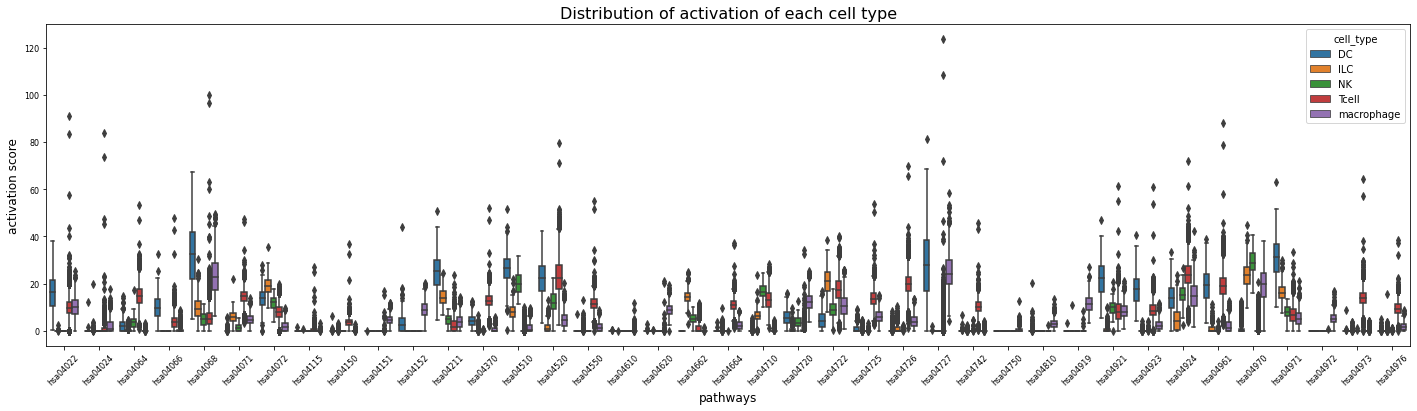

In [15]:
# to visualize the distribution for each pathway, pd.melt operation applied into df_plot dataset
# visualization of the activities of all pathway according to cell_type
order_train = sorted(list(set(df_raw['cell_type'].values)))
plt.figure(figsize=(20,6))
sns.boxplot(x='variable', y='value', data=pd.melt(df_active, id_vars='cell_type'), hue='cell_type', hue_order=dict(zip(order_train, range(len(order_train)))))
plt.xticks(rotation=45);
plt.title('Distribution of activation of each cell type')
plt.xlabel('pathways')
plt.ylabel('activation score')
plt.tight_layout()
# exporting the graph
plt.savefig(os.path.join(loc_output, 'distribution_activities.png'), dpi=300, bbox_inches = 'tight')